## Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Load Dataset

In [4]:
# Load from Dropbox URL
data = pd.read_csv('https://www.dropbox.com/scl/fi/yis5zpl35tyn2r3z4d7uf/real_estate_market_data.csv?rlkey=oa1106yj6knt6w1oufogdpequ&st=571k3go0&dl=1')

print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.shape[1]}")
data.head()

Dataset shape: (2829, 74)
Columns: 74


,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,NaN,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,NaN,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,3,2010,WD,Normal,189900,-93.638933,42.060899


## Step 3: Explore Data

In [5]:
# Check numerical vs categorical columns
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")
print(f"Total features: {len(num_cols) + len(cat_cols) - 1}")  # -1 for Sale_Price

print(f"\nTarget variable (Sale_Price) statistics:")
print(data['Sale_Price'].describe())

Numerical columns: 34
Categorical columns: 40
Total features: 73

Target variable (Sale_Price) statistics:
count      2829.000000
mean     180599.798515
std       80026.784594
min       12789.000000
25%      129000.000000
50%      160000.000000
75%      213250.000000
max      755000.000000
Name: Sale_Price, dtype: float64


In [6]:
# Check missing values
missing = data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:")
print(missing)

Columns with missing values:
Misc_Feature    2730
Mas_Vnr_Type    1711
dtype: int64


## Step 4: Preprocessing — Separate Features & Target

In [7]:
# Separate target variable
y = data['Sale_Price']
X = data.drop(columns=['Sale_Price'])

print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

Features: 73
Samples: 2829


## Step 5: Encode Categorical Variables & Handle Missing Values

In [8]:
# Handle categorical variables with Label Encoding
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Encoding {len(cat_cols)} categorical columns...")

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = X[col].fillna('Missing')
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

Encoding 40 categorical columns...


In [9]:
# Handle missing values in numerical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print("✓ Preprocessing complete!")
print(f"Features after encoding: {X.shape[1]}")

✓ Preprocessing complete!
Features after encoding: 73


## Step 6: Feature Engineering — Create 13 New Features

In [10]:
# Feature Engineering - Create 13 new features
X['Total_SF'] = X['Gr_Liv_Area'] + X['Total_Bsmt_SF']
X['Total_Bath'] = X['Full_Bath'] + 0.5 * X['Half_Bath'] + X['Bsmt_Full_Bath'] + 0.5 * X['Bsmt_Half_Bath']
X['Age'] = X['Year_Sold'] - X['Year_Built']
X['Remod_Age'] = X['Year_Sold'] - X['Year_Remod_Add']
X['Total_Porch_SF'] = X['Wood_Deck_SF'] + X['Open_Porch_SF'] + X['Enclosed_Porch'] + X['Screen_Porch']
X['Has_Pool'] = (X['Pool_Area'] > 0).astype(int)
X['Has_Garage'] = (X['Garage_Area'] > 0).astype(int)
X['Has_Basement'] = (X['Total_Bsmt_SF'] > 0).astype(int)
X['Quality_SF'] = X['Gr_Liv_Area'] * X['Overall_Cond']
X['Garage_to_Living'] = X['Garage_Area'] / (X['Gr_Liv_Area'] + 1)
X['Lot_to_Living'] = X['Lot_Area'] / (X['Gr_Liv_Area'] + 1)
X['Total_Rooms'] = X['TotRms_AbvGrd'] + X['Bedroom_AbvGr'] + X['Kitchen_AbvGr']
X['Bed_Bath_Ratio'] = X['Bedroom_AbvGr'] / (X['Full_Bath'] + 0.5 * X['Half_Bath'] + 0.1)

print(f"✓ Added 13 engineered features")
print(f"Total features now: {X.shape[1]}")

✓ Added 13 engineered features
Total features now: 86


## Step 7: Log Transform Target Variable

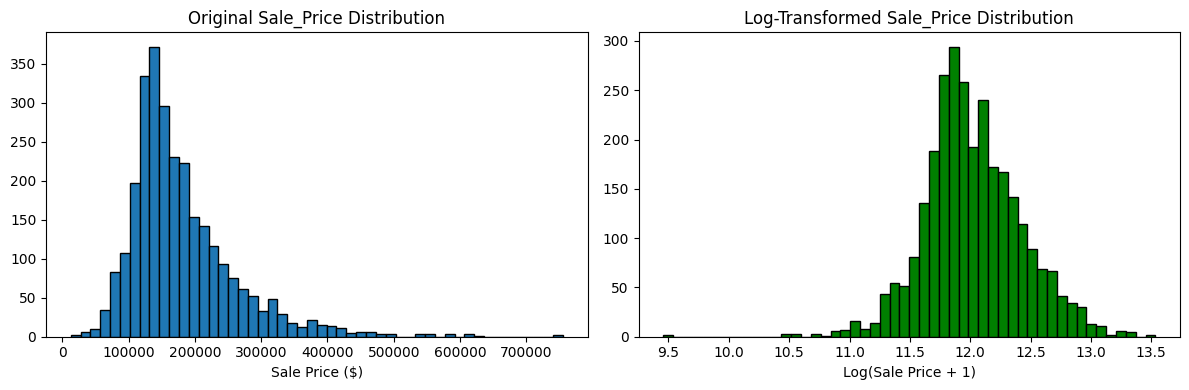

Log transformation helps normalize the skewed distribution!


In [11]:
# Log transform the target variable
y_log = np.log1p(y)

# Visualize the transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y, bins=50, edgecolor='black')
axes[0].set_title('Original Sale_Price Distribution')
axes[0].set_xlabel('Sale Price ($)')

axes[1].hist(y_log, bins=50, edgecolor='black', color='green')
axes[1].set_title('Log-Transformed Sale_Price Distribution')
axes[1].set_xlabel('Log(Sale Price + 1)')

plt.tight_layout()
plt.show()

print("Log transformation helps normalize the skewed distribution!")

## Step 8: Train/Test Split

In [12]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
_, _, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1980 samples
Test set: 849 samples


## Step 9: Define MAPE Function

In [13]:
def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAPE function defined!")
print("Formula: MAPE = mean(|actual - predicted| / actual) * 100")

MAPE function defined!
Formula: MAPE = mean(|actual - predicted| / actual) * 100


## Step 10: Model Comparison — Train 4 Models

In [14]:
print("="*60)
print("MODEL COMPARISON")
print("="*60)

results = {}

# 1. Random Forest (baseline approach)
print("\n1. Training Random Forest...")
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_mape = mape(y_test, rf_pred)
results['Random Forest'] = rf_mape
print(f"   MAPE: {rf_mape:.4f}%")

# 2. Gradient Boosting
print("\n2. Training Gradient Boosting...")
gb = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train_log)
gb_pred = np.expm1(gb.predict(X_test))
gb_mape = mape(y_test, gb_pred)
results['Gradient Boosting'] = gb_mape
print(f"   MAPE: {gb_mape:.4f}%")

# 3. XGBoost
print("\n3. Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train_log, eval_set=[(X_test, y_test_log)], verbose=False)
xgb_pred = np.expm1(xgb_model.predict(X_test))
xgb_mape = mape(y_test, xgb_pred)
results['XGBoost'] = xgb_mape
print(f"   MAPE: {xgb_mape:.4f}%")

# 4. LightGBM
print("\n4. Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=500, max_depth=8, learning_rate=0.05,
    num_leaves=50, subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, verbose=-1
)
lgb_model.fit(X_train, y_train_log)
lgb_pred = np.expm1(lgb_model.predict(X_test))
lgb_mape = mape(y_test, lgb_pred)
results['LightGBM'] = lgb_mape
print(f"   MAPE: {lgb_mape:.4f}%")

print("\n" + "="*60)

MODEL COMPARISON

1. Training Random Forest...
   MAPE: 9.8344%

2. Training Gradient Boosting...
   MAPE: 8.6236%

3. Training XGBoost...
   MAPE: 8.4851%

4. Training LightGBM...
   MAPE: 8.4824%



## Step 11: Visualize Model Comparison

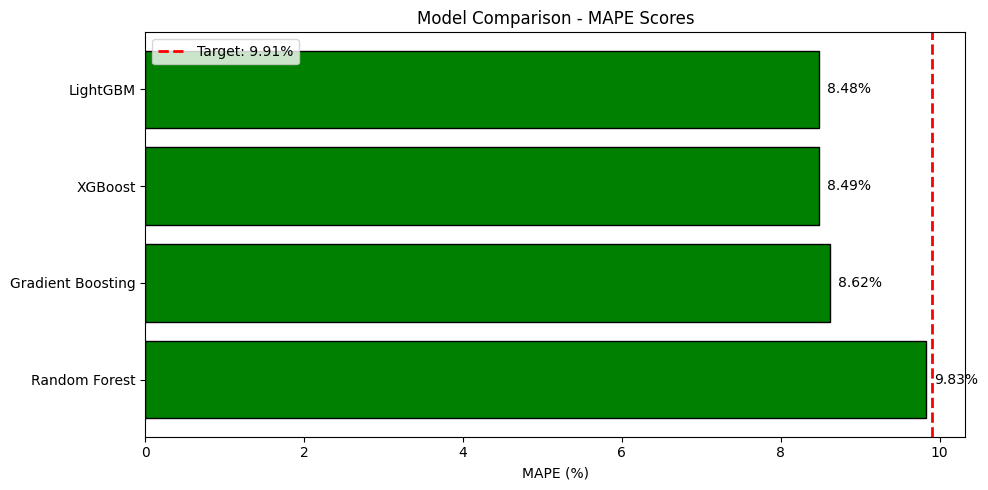


Best model: LightGBM with MAPE: 8.4824%


In [15]:
# Visualize model comparison
plt.figure(figsize=(10, 5))
models = list(results.keys())
mapes = list(results.values())
colors = ['green' if m < 9.91 else 'red' for m in mapes]

bars = plt.barh(models, mapes, color=colors, edgecolor='black')
plt.axvline(x=9.91, color='red', linestyle='--', linewidth=2, label='Target: 9.91%')
plt.xlabel('MAPE (%)')
plt.title('Model Comparison - MAPE Scores')
plt.legend()

# Add value labels
for bar, val in zip(bars, mapes):
    plt.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.2f}%', va='center')

plt.tight_layout()
plt.show()

print(f"\nBest model: {min(results, key=results.get)} with MAPE: {min(results.values()):.4f}%")

## Step 12: Tuned XGBoost (Best Model)

In [16]:
print("Training Tuned XGBoost...")

xgb_tuned = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.02,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

xgb_tuned.fit(X_train, y_train_log, eval_set=[(X_test, y_test_log)], verbose=False)

# Predictions
xgb_tuned_pred = np.expm1(xgb_tuned.predict(X_test))
xgb_tuned_mape = mape(y_test, xgb_tuned_pred)

print(f"\n{'='*60}")
print(f"TUNED XGBOOST RESULTS")
print(f"{'='*60}")
print(f"MAPE: {xgb_tuned_mape:.4f}%")
print(f"Target: 9.91%")
print(f"Improvement: {9.91 - xgb_tuned_mape:.4f}%")
print(f"{'='*60}")

Training Tuned XGBoost...

TUNED XGBOOST RESULTS
MAPE: 8.2323%
Target: 9.91%
Improvement: 1.6777%


## Step 13: 5-Fold Cross-Validation

In [17]:
print("Running 5-Fold Cross-Validation...")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mapes = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    y_train_log_cv = np.log1p(y_train_cv)

    model = xgb.XGBRegressor(
        n_estimators=1000, max_depth=5, learning_rate=0.02,
        subsample=0.7, colsample_bytree=0.7,
        reg_alpha=0.1, reg_lambda=1.0, min_child_weight=3,
        random_state=42, n_jobs=-1
    )
    model.fit(X_train_cv, y_train_log_cv, verbose=False)

    y_pred_cv = np.expm1(model.predict(X_val_cv))
    fold_mape = mape(y_val_cv, y_pred_cv)
    cv_mapes.append(fold_mape)
    print(f"Fold {fold+1}: MAPE = {fold_mape:.4f}%")

print(f"\n{'='*60}")
print(f"CROSS-VALIDATION RESULTS")
print(f"{'='*60}")
print(f"Mean MAPE:  {np.mean(cv_mapes):.4f}% ± {np.std(cv_mapes):.4f}%")
print(f"Target:     9.91%")
print(f"Improvement: {9.91 - np.mean(cv_mapes):.4f}%")
print(f"{'='*60}")

Running 5-Fold Cross-Validation...
Fold 1: MAPE = 8.4013%
Fold 2: MAPE = 7.6705%
Fold 3: MAPE = 8.8024%
Fold 4: MAPE = 8.0818%
Fold 5: MAPE = 8.5876%

CROSS-VALIDATION RESULTS
Mean MAPE:  8.3087% ± 0.3972%
Target:     9.91%
Improvement: 1.6013%


## Step 14: Feature Importance

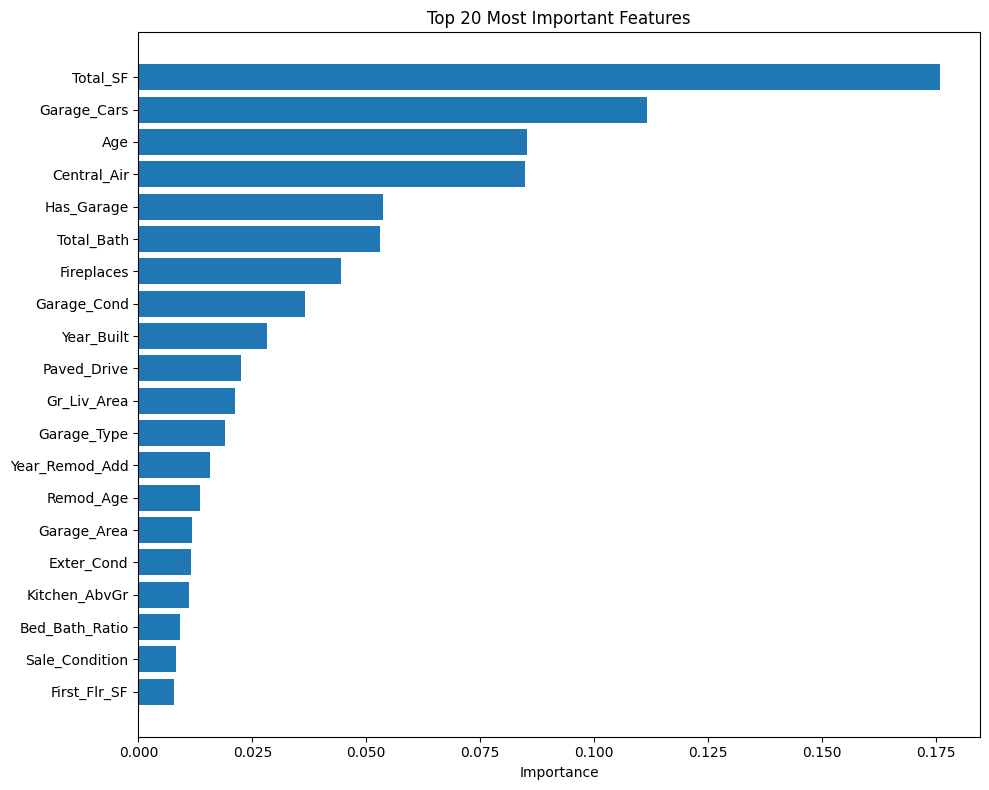

Top 10 most important features:
    Feature  Importance
   Total_SF    0.175885
Garage_Cars    0.111658
        Age    0.085242
Central_Air    0.084741
 Has_Garage    0.053686
 Total_Bath    0.053106
 Fireplaces    0.044512
Garage_Cond    0.036474
 Year_Built    0.028197
Paved_Drive    0.022404


In [18]:
# Get feature importances from tuned model
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_20 = importance_df.head(20)
plt.barh(top_20['Feature'], top_20['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(importance_df.head(10).to_string(index=False))

## Step 15: Load Prediction Data (New/Unseen Data)

In [19]:
# Load prediction data
predictions = pd.read_csv('https://www.dropbox.com/scl/fi/aol0myehwcdo093zvu0j5/real_estate_predictions.csv?rlkey=uhap0mzv2bnra08hocn96ezrz&st=88j2x1g4&dl=1')

# Or load from local file:
# predictions = pd.read_csv('real_estate_predictions.csv')

print(f"Prediction data shape: {predictions.shape}")
print(f"\nSale_Price column has {predictions['Sale_Price'].isna().sum()} missing values (out of {len(predictions)})")
predictions.head()

Prediction data shape: (100, 74)

Sale_Price column has 100 missing values (out of 100)


,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_PUD_1946_and_Newer,Residential_Medium_Density,35,3907,Pave,No_Alley_Access,Slightly_Irregular,HLS,AllPub,Inside,...,No_Fence,NaN,0,4,2010,WD,Normal,NaN,-93.645701,42.009345
1,One_Story_PUD_1946_and_Newer,Residential_Medium_Density,35,3907,Pave,No_Alley_Access,Slightly_Irregular,HLS,AllPub,Inside,...,No_Fence,NaN,0,3,2010,WD,Normal,NaN,-93.645729,42.009337
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,100,15602,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Good_Wood,NaN,0,3,2010,WD,Normal,NaN,-93.641677,42.010797
3,One_and_Half_Story_Finished_All_Ages,Residential_Medium_Density,40,5436,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,5,2010,WD,Normal,NaN,-93.625291,42.022772
4,One_Story_1945_and_Older,Residential_Medium_Density,58,8154,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Fence,NaN,0,4,2010,ConLw,Normal,NaN,-93.629496,42.021414


## Step 16: Preprocess Prediction Data (Same Pipeline as Training)

In [20]:
# Preprocess prediction data (same steps as training)
X_pred = predictions.drop(columns=['Sale_Price'])

# Encode categorical variables using saved encoders
cat_cols = X_pred.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    X_pred[col] = X_pred[col].fillna('Missing')
    known = set(le_dict[col].classes_)
    X_pred[col] = X_pred[col].apply(lambda x: x if x in known else 'Missing')
    X_pred[col] = le_dict[col].transform(X_pred[col])

# Fill missing numerical values
num_cols = X_pred.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    X_pred[col] = X_pred[col].fillna(X[col].median())

# Add engineered features (same 13 features)
X_pred['Total_SF'] = X_pred['Gr_Liv_Area'] + X_pred['Total_Bsmt_SF']
X_pred['Total_Bath'] = X_pred['Full_Bath'] + 0.5 * X_pred['Half_Bath'] + X_pred['Bsmt_Full_Bath'] + 0.5 * X_pred['Bsmt_Half_Bath']
X_pred['Age'] = X_pred['Year_Sold'] - X_pred['Year_Built']
X_pred['Remod_Age'] = X_pred['Year_Sold'] - X_pred['Year_Remod_Add']
X_pred['Total_Porch_SF'] = X_pred['Wood_Deck_SF'] + X_pred['Open_Porch_SF'] + X_pred['Enclosed_Porch'] + X_pred['Screen_Porch']
X_pred['Has_Pool'] = (X_pred['Pool_Area'] > 0).astype(int)
X_pred['Has_Garage'] = (X_pred['Garage_Area'] > 0).astype(int)
X_pred['Has_Basement'] = (X_pred['Total_Bsmt_SF'] > 0).astype(int)
X_pred['Quality_SF'] = X_pred['Gr_Liv_Area'] * X_pred['Overall_Cond']
X_pred['Garage_to_Living'] = X_pred['Garage_Area'] / (X_pred['Gr_Liv_Area'] + 1)
X_pred['Lot_to_Living'] = X_pred['Lot_Area'] / (X_pred['Gr_Liv_Area'] + 1)
X_pred['Total_Rooms'] = X_pred['TotRms_AbvGrd'] + X_pred['Bedroom_AbvGr'] + X_pred['Kitchen_AbvGr']
X_pred['Bed_Bath_Ratio'] = X_pred['Bedroom_AbvGr'] / (X_pred['Full_Bath'] + 0.5 * X_pred['Half_Bath'] + 0.1)

# Ensure same columns as training
X_pred = X_pred.reindex(columns=X.columns, fill_value=0)

print(f"✓ Preprocessed {X_pred.shape[0]} samples with {X_pred.shape[1]} features")

✓ Preprocessed 100 samples with 86 features


## Step 17: Train Final Model on Full Data & Generate Predictions

In [21]:
# Train final model on ALL training data
print("Training final model on full dataset...")

final_model = xgb.XGBRegressor(
    n_estimators=1000, max_depth=5, learning_rate=0.02,
    subsample=0.7, colsample_bytree=0.7,
    reg_alpha=0.1, reg_lambda=1.0, min_child_weight=3,
    random_state=42, n_jobs=-1
)
final_model.fit(X, y_log, verbose=False)

# Generate predictions
pred_log = final_model.predict(X_pred)
pred_prices = np.expm1(pred_log)

# Add predictions to dataframe
predictions['Sale_Price'] = pred_prices

print(f"\n✓ Generated {len(pred_prices)} predictions")
print(f"\nPrediction statistics:")
print(f"  Min:    ${pred_prices.min():,.0f}")
print(f"  Max:    ${pred_prices.max():,.0f}")
print(f"  Mean:   ${pred_prices.mean():,.0f}")
print(f"  Median: ${np.median(pred_prices):,.0f}")

Training final model on full dataset...

✓ Generated 100 predictions

Prediction statistics:
  Min:    $65,689
  Max:    $466,453
  Mean:   $183,612
  Median: $174,701


## Step 18: Save Predictions & Preview

In [22]:
# Save to CSV
predictions.to_csv('team_predictions.csv', index=False)
print("✓ Predictions saved to 'team_predictions.csv'")

# Preview
predictions[['Neighborhood', 'Gr_Liv_Area', 'TotRms_AbvGrd', 'Bldg_Type', 'Sale_Price']].head(10)

✓ Predictions saved to 'team_predictions.csv'


,Neighborhood,Gr_Liv_Area,TotRms_AbvGrd,Bldg_Type,Sale_Price
0,Blueste,1034,4,TwnhsE,172403.234375
1,Blueste,1191,5,TwnhsE,168989.484375
2,Crawford,1801,6,OneFam,270142.375000
3,Iowa_DOT_and_Rail_Road,1154,7,OneFam,124975.484375
4,Iowa_DOT_and_Rail_Road,540,4,OneFam,65688.804688
5,Iowa_DOT_and_Rail_Road,1107,5,OneFam,114209.085938
6,Iowa_DOT_and_Rail_Road,1128,6,OneFam,85894.812500
7,Iowa_DOT_and_Rail_Road,1178,7,OneFam,88306.078125
8,Iowa_DOT_and_Rail_Road,1044,4,OneFam,80249.070312
9,Iowa_DOT_and_Rail_Road,952,5,OneFam,87331.726562


## Step 19: MAPE Visualization

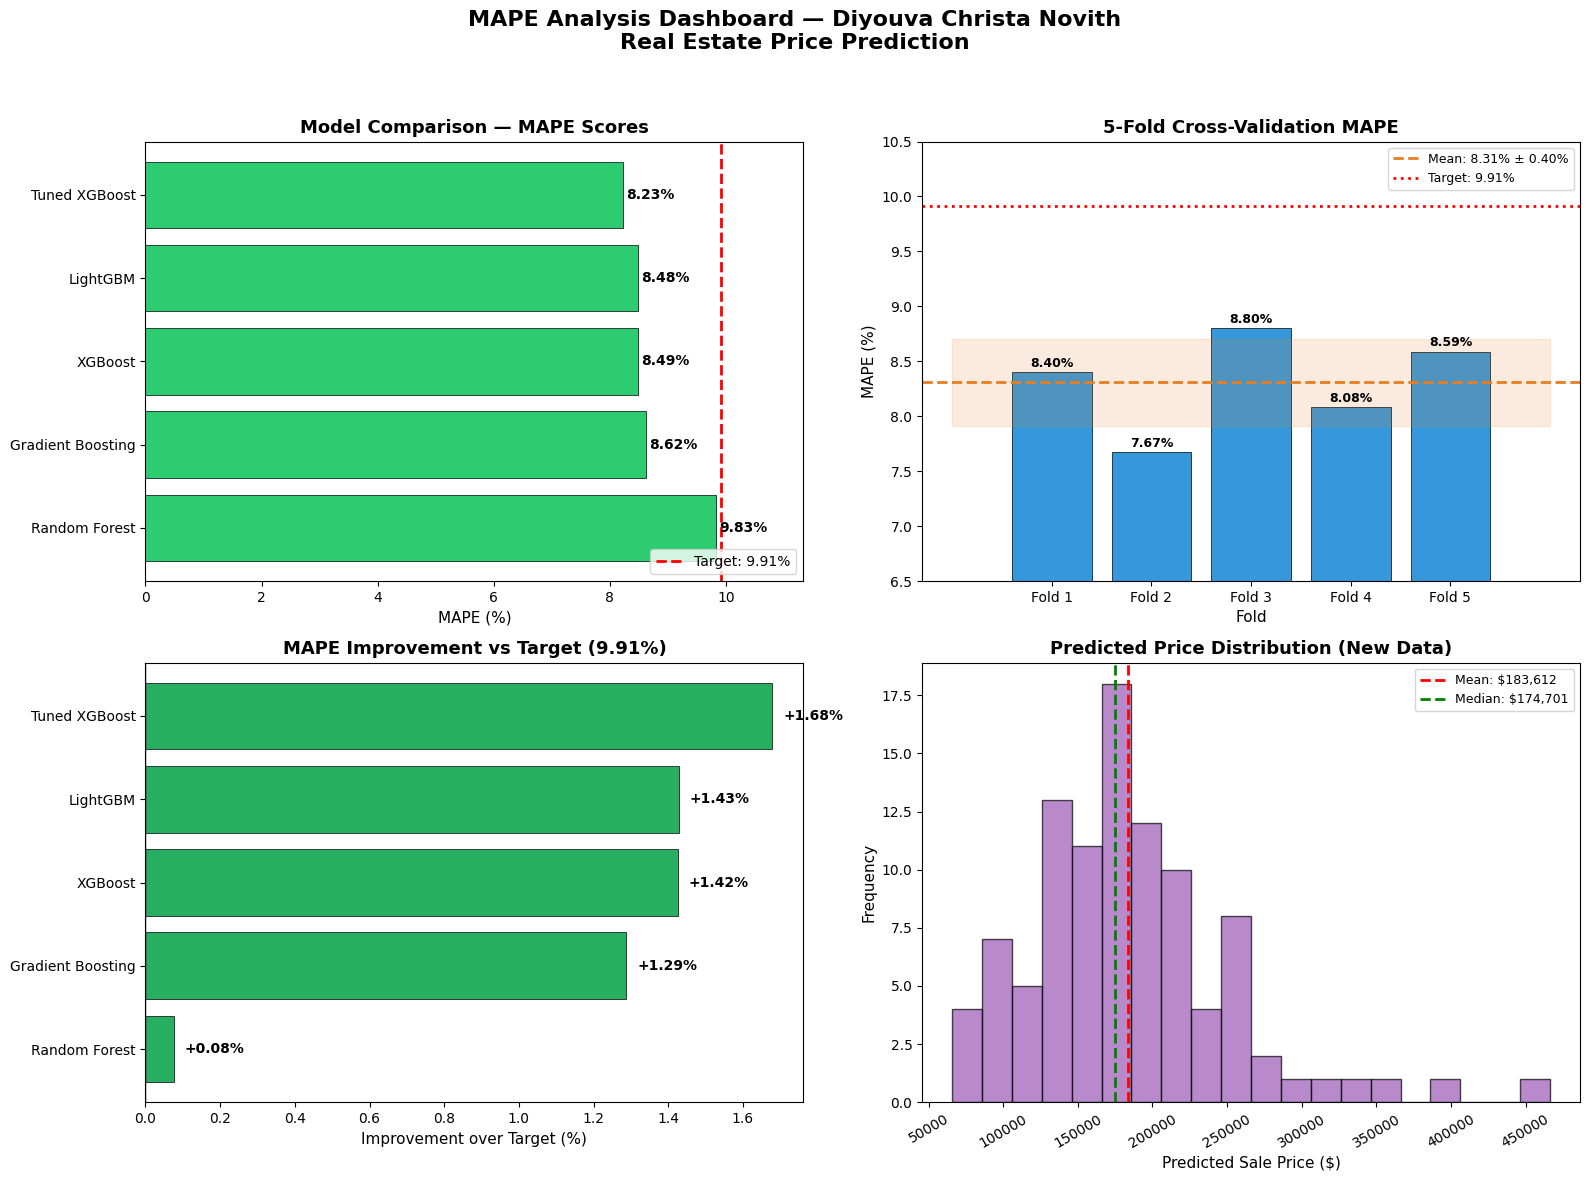

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MAPE Analysis Dashboard — Diyouva Christa Novith\nReal Estate Price Prediction',
             fontsize=16, fontweight='bold', y=0.98)

# Plot 1: Model Comparison Bar Chart
ax1 = axes[0, 0]
all_models = list(results.keys()) + ['Tuned XGBoost']
all_mapes = list(results.values()) + [xgb_tuned_mape]
colors = ['#2ecc71' if m < 9.91 else '#e74c3c' for m in all_mapes]

bars = ax1.barh(all_models, all_mapes, color=colors, edgecolor='black', linewidth=0.5)
ax1.axvline(x=9.91, color='red', linestyle='--', linewidth=2, label='Target: 9.91%')
ax1.set_xlabel('MAPE (%)', fontsize=11)
ax1.set_title('Model Comparison — MAPE Scores', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
for bar, val in zip(bars, all_mapes):
    ax1.text(val + 0.05, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}%', va='center', fontsize=10, fontweight='bold')
ax1.set_xlim(0, max(all_mapes) + 1.5)

# Plot 2: Cross-Validation MAPE per Fold
ax2 = axes[0, 1]
fold_names = [f'Fold {i+1}' for i in range(5)]
fold_colors = ['#3498db'] * 5
cv_mean = np.mean(cv_mapes)
cv_std = np.std(cv_mapes)

bars2 = ax2.bar(fold_names, cv_mapes, color=fold_colors, edgecolor='black', linewidth=0.5)
ax2.axhline(y=cv_mean, color='#e67e22', linestyle='--', linewidth=2,
            label=f'Mean: {cv_mean:.2f}% ± {cv_std:.2f}%')
ax2.axhline(y=9.91, color='red', linestyle=':', linewidth=2, label='Target: 9.91%')
ax2.fill_between(range(-1, 6), cv_mean - cv_std, cv_mean + cv_std,
                 alpha=0.15, color='#e67e22')
ax2.set_xlabel('Fold', fontsize=11)
ax2.set_ylabel('MAPE (%)', fontsize=11)
ax2.set_title('5-Fold Cross-Validation MAPE', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.set_ylim(6.5, 10.5)
for bar, val in zip(bars2, cv_mapes):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.05,
             f'{val:.2f}%', ha='center', fontsize=9, fontweight='bold')
    
# Plot 3: MAPE Improvement Over Target
ax3 = axes[1, 0]
target = 9.91
improvements = [target - m for m in all_mapes]
imp_colors = ['#27ae60' if v > 0 else '#c0392b' for v in improvements]

bars3 = ax3.barh(all_models, improvements, color=imp_colors, edgecolor='black', linewidth=0.5)
ax3.axvline(x=0, color='black', linewidth=1)
ax3.set_xlabel('Improvement over Target (%)', fontsize=11)
ax3.set_title('MAPE Improvement vs Target (9.91%)', fontsize=13, fontweight='bold')
for bar, val in zip(bars3, improvements):
    offset = 0.03 if val >= 0 else -0.03
    ha = 'left' if val >= 0 else 'right'
    ax3.text(val + offset, bar.get_y() + bar.get_height()/2,
             f'{val:+.2f}%', va='center', ha=ha, fontsize=10, fontweight='bold')
    
# Plot 4: Prediction Distribution on New Data
ax4 = axes[1, 1]
ax4.hist(pred_prices, bins=20, edgecolor='black', color='#9b59b6', alpha=0.7)
ax4.axvline(x=pred_prices.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: ${pred_prices.mean():,.0f}')
ax4.axvline(x=np.median(pred_prices), color='green', linestyle='--', linewidth=2,
            label=f'Median: ${np.median(pred_prices):,.0f}')
ax4.set_xlabel('Predicted Sale Price ($)', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Predicted Price Distribution (New Data)', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.ticklabel_format(style='plain', axis='x')
ax4.tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Step 20: Final Summary

In [28]:
print("="*60)
print("FINAL SUMMARY — Diyouva Christa Novith")
print("="*60)

print("\n MODEL RESULTS (Test Set MAPE):")
for name, score in results.items():
    status = "✓" if score < 9.91 else "✗"
    print(f"  {status} {name:25s} → MAPE: {score:.4f}%")
print(f"  ✓ {'Tuned XGBoost':25s} → MAPE: {xgb_tuned_mape:.4f}%  ← BEST")

print(f"\n CROSS-VALIDATION:")
print(f"  Mean MAPE: {np.mean(cv_mapes):.4f}% ± {np.std(cv_mapes):.4f}%")

print(f"\n TARGET: 9.91%")
print(f"  Best improvement: {9.91 - xgb_tuned_mape:.4f}%")

print(f"\n PREDICTIONS ON NEW DATA (100 properties):")
print(f"  Mean:   ${pred_prices.mean():,.0f}")
print(f"  Median: ${np.median(pred_prices):,.0f}")
print(f"  Range:  ${pred_prices.min():,.0f} — ${pred_prices.max():,.0f}")

FINAL SUMMARY — Diyouva Christa Novith

 MODEL RESULTS (Test Set MAPE):
  ✓ Random Forest             → MAPE: 9.8344%
  ✓ Gradient Boosting         → MAPE: 8.6236%
  ✓ XGBoost                   → MAPE: 8.4851%
  ✓ LightGBM                  → MAPE: 8.4824%
  ✓ Tuned XGBoost             → MAPE: 8.2323%  ← BEST

 CROSS-VALIDATION:
  Mean MAPE: 8.3087% ± 0.3972%

 TARGET: 9.91%
  Best improvement: 1.6777%

 PREDICTIONS ON NEW DATA (100 properties):
  Mean:   $183,612
  Median: $174,701
  Range:  $65,689 — $466,453
